# 构建分类模型：美味的亚洲和印度美食


## 美食分类器 1

在本课中，我们将探索多种分类器来*根据一组食材预测某种国家美食*。同时，我们将深入了解算法在分类任务中的一些应用方式。

### [**课前测验**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **准备工作**

本课基于我们[上一课](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb)，其中我们：

-   使用一个关于亚洲和印度各种美食的数据集进行了分类的简单介绍 😋。

-   探索了一些 [dplyr 动词](https://dplyr.tidyverse.org/) 来准备和清理数据。

-   使用 ggplot2 创建了漂亮的可视化图表。

-   演示了如何通过使用 [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html) 预处理数据来处理不平衡数据。

-   演示了如何 `prep` 和 `bake` 我们的配方，以确认其能够正常工作。

#### **前置条件**

在本课中，我们需要以下包来清理、准备和可视化数据：

-   `tidyverse`： [tidyverse](https://www.tidyverse.org/) 是一个 [R 包集合](https://www.tidyverse.org/packages)，旨在让数据科学更快、更简单、更有趣！

-   `tidymodels`： [tidymodels](https://www.tidymodels.org/) 框架是一个 [包集合](https://www.tidymodels.org/packages)，用于建模和机器学习。

-   `themis`： [themis 包](https://themis.tidymodels.org/) 提供了额外的配方步骤，用于处理不平衡数据。

-   `nnet`： [nnet 包](https://cran.r-project.org/web/packages/nnet/nnet.pdf) 提供了用于估计具有单个隐藏层的前馈神经网络以及多项逻辑回归模型的函数。

您可以通过以下方式安装这些包：


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

或者，下面的脚本会检查您是否已安装完成本模块所需的包，并在缺少时为您安装。


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. 将数据分为训练集和测试集

我们将从上一节课中选择几个步骤开始。

### 使用 `dplyr::select()` 删除最常见的食材，这些食材容易在不同菜系之间造成混淆。

谁不喜欢米饭、大蒜和姜呢！


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
indian,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0


cuisine,n
<fct>,<int>
korean,799
indian,598
chinese,442
japanese,320
thai,289


太棒了！现在是时候将数据分割为70%用于训练，30%用于测试。我们还将应用一种`分层`技术，在分割数据时`保持每种菜系的比例`在训练和验证数据集中。

[rsample](https://rsample.tidymodels.org/)是Tidymodels中的一个包，它提供了高效的数据分割和重采样的基础设施：


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine,almond,angelica,anise,anise_seed,apple,apple_brandy,apricot,armagnac,artemisia,⋯,whiskey,white_bread,white_wine,whole_grain_wheat_flour,wine,wood,yam,yeast,yogurt,zucchini
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
chinese,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


cuisine,n
<fct>,<int>
korean,559
indian,418
chinese,309
japanese,224
thai,202


## 2. 处理数据不平衡

正如你可能在原始数据集以及我们的训练集里注意到的，菜系的数量分布非常不均衡。韩餐的数量几乎是泰餐的*三倍*。数据不平衡通常会对模型性能产生负面影响。许多模型在观察数量相等时表现最佳，因此在处理不平衡数据时往往会遇到困难。

处理数据不平衡主要有两种方法：

-   为少数类别增加观察值：`过采样`，例如使用 SMOTE 算法，该算法通过少数类别的邻近样本合成生成新的样本。

-   从多数类别中移除观察值：`欠采样`

在之前的课程中，我们演示了如何使用 `recipe` 来处理数据不平衡问题。`recipe` 可以被看作是一个蓝图，描述了应该对数据集应用哪些步骤以使其准备好进行数据分析。在我们的案例中，我们希望在 `训练集` 中实现菜系数量的均衡分布。让我们直接开始吧。


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

您当然可以通过准备和烘焙来确认这份配方是否如预期般有效——所有标有“559”观察值的菜系标签。

由于我们将使用这份配方作为建模的预处理器，`workflow()`将为我们完成所有的准备和烘焙工作，因此我们无需手动估算配方。

现在我们准备开始训练模型了 👩‍💻👨‍💻！

## 3. 选择您的分类器

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>插画作者：@allison_horst</figcaption>


现在我们需要决定使用哪种算法来完成任务 🤔。

在 Tidymodels 中，[`parsnip package`](https://parsnip.tidymodels.org/index.html) 提供了一个一致的接口，用于跨不同引擎（包）处理模型。请参阅 parsnip 文档，探索[模型类型和引擎](https://www.tidymodels.org/find/parsnip/#models)及其对应的[模型参数](https://www.tidymodels.org/find/parsnip/#model-args)。乍一看，种类繁多令人眼花缭乱。例如，以下方法都包括分类技术：

-   C5.0规则分类模型

-   灵活判别模型

-   线性判别模型

-   正则化判别模型

-   逻辑回归模型

-   多项式回归模型

-   朴素贝叶斯模型

-   支持向量机

-   最近邻算法

-   决策树

-   集成方法

-   神经网络

这个列表还在继续！

### **选择哪种分类器？**

那么，应该选择哪种分类器呢？通常，通过尝试多个分类器并寻找效果较好的结果是一种测试方法。

> AutoML 通过在云端运行这些比较，巧妙地解决了这个问题，让你可以选择最适合数据的算法。试试 [这里](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

此外，分类器的选择取决于我们的问题。例如，当结果可以被分类为`多于两个类别`时，就像我们的情况一样，你必须使用`多分类算法`而不是`二分类算法`。

### **更好的方法**

比盲目猜测更好的方法是参考这个可下载的[机器学习速查表](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott)。在这里，我们发现，对于我们的多分类问题，我们有一些选择：

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>微软算法速查表的一部分，详细介绍了多分类选项</figcaption>


### **推理**

让我们根据现有的约束条件来分析不同的方法：

-   **深度神经网络过于复杂**。考虑到我们数据集虽然干净但规模较小，并且我们是在本地通过笔记本运行训练，深度神经网络对于这个任务来说过于笨重。

-   **不使用二分类分类器**。我们不使用二分类分类器，因此排除了“一对多”的方法。

-   **决策树或逻辑回归可能适用**。决策树可能有效，或者可以使用多项式回归/多分类逻辑回归来处理多分类数据。

-   **多分类提升决策树解决的是不同的问题**。多分类提升决策树最适合非参数任务，例如用于构建排名的任务，因此对我们来说并不适用。

此外，通常在尝试更复杂的机器学习模型（例如集成方法）之前，构建一个最简单的模型来了解数据情况是一个好主意。因此，在本课程中，我们将从一个`多项式回归`模型开始。

> 逻辑回归是一种用于结果变量是分类（或名义）时的技术。对于二元逻辑回归，结果变量的数量是两个，而对于多项式逻辑回归，结果变量的数量超过两个。有关更多信息，请参阅[高级回归方法](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html)。

## 4. 训练并评估一个多项式逻辑回归模型

在Tidymodels中，`parsnip::multinom_reg()`定义了一个使用线性预测器通过多项式分布预测多分类数据的模型。有关使用此模型的不同方法/引擎，请参阅`?multinom_reg()`。

在这个示例中，我们将通过默认的[nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf)引擎来拟合一个多项式回归模型。

> 我随机选择了一个`penalty`值。实际上有更好的方法来选择这个值，例如通过`重采样`和`调参`模型，这些内容我们稍后会讨论。
>
> 如果您想了解更多关于如何调节模型超参数的信息，请参阅[Tidymodels: 入门](https://www.tidymodels.org/start/tuning/)。


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


干得好 🥳！现在我们已经有了一个配方和一个模型规范，我们需要找到一种方法将它们打包到一个对象中，这个对象首先会对数据进行预处理，然后将模型拟合到预处理后的数据上，同时还允许进行潜在的后处理操作。在 Tidymodels 中，这个方便的对象叫做 [`workflow`](https://workflows.tidymodels.org/)，它可以方便地保存你的建模组件！这在 *Python* 中我们称之为 *pipelines*。

那么，让我们把所有内容打包到一个 workflow 中吧！📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


工作流 👌👌！一个 **`workflow()`** 可以像模型一样进行拟合。所以，是时候训练一个模型了！


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

输出显示了模型在训练过程中学习到的系数。

### 评估训练好的模型

现在是时候通过在测试集上评估模型来看看它的表现了 📏！让我们从对测试集进行预测开始吧。


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine,.pred_class
<fct>,<fct>
indian,thai
indian,indian
indian,indian
indian,indian
indian,indian


干得好！在Tidymodels中，可以使用[yardstick](https://yardstick.tidymodels.org/)评估模型性能——这是一个通过性能指标来衡量模型效果的工具包。正如我们在逻辑回归课程中所做的那样，让我们从计算混淆矩阵开始。


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

当处理多个类别时，通常更直观的方式是将其可视化为热图，如下所示：


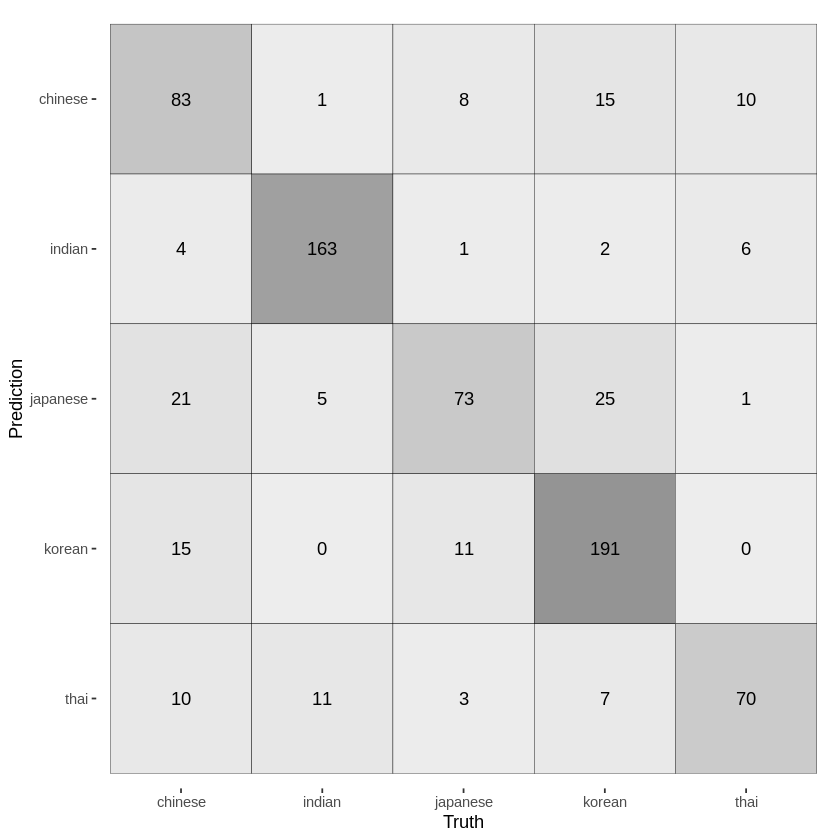

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

混淆矩阵图中较深的方块表示案例数量较多，希望你能看到一条较深方块组成的对角线，表明预测标签与实际标签一致的情况。

现在让我们计算混淆矩阵的汇总统计数据。


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7880435
kap,multiclass,0.7276583
sens,macro,0.7780927
spec,macro,0.9477598
ppv,macro,0.7585583
npv,macro,0.9460080
mcc,multiclass,0.7292724
j_index,macro,0.7258524
bal_accuracy,macro,0.8629262


如果我们仅关注一些指标，比如准确率、敏感性、PPV，作为开始，我们的表现还不错 🥳！

## 4. 深入探讨

让我们问一个微妙的问题：选择某种菜系作为预测结果的标准是什么？

实际上，统计机器学习算法，比如逻辑回归，是基于`概率`的；分类器真正预测的是一组可能结果的概率分布。然后，概率最高的类别会被选为给定观察数据中最可能的结果。

让我们通过同时进行硬分类预测和概率预测来看看实际效果。


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine,.pred_class,.pred_chinese,.pred_indian,.pred_japanese,.pred_korean,.pred_thai
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
indian,thai,1.551259e-03,0.4587877,5.988039e-04,2.428503e-04,5.388194e-01
indian,indian,2.637133e-05,0.9999488,6.648651e-07,2.259993e-05,1.577948e-06
indian,indian,1.049433e-03,0.9909982,1.060937e-03,1.644947e-05,6.874989e-03
indian,indian,6.237482e-02,0.4763035,9.136702e-02,3.660913e-01,3.863391e-03
indian,indian,1.431745e-02,0.9418551,2.945239e-02,8.721782e-03,5.653283e-03


为什么模型非常确定第一条观察是泰国菜？

## **🚀挑战**

在本课中，你使用清理后的数据构建了一个机器学习模型，可以根据一系列食材预测国家菜系。花点时间阅读 [Tidymodels 提供的多种选项](https://www.tidymodels.org/find/parsnip/#models) 来分类数据，以及 [其他方法](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) 来拟合多项式回归。

#### 感谢：

[`Allison Horst`](https://twitter.com/allison_horst/) 创作了令人惊叹的插图，使 R 更加友好和吸引人。可以在她的 [画廊](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM) 中找到更多插图。

[Cassie Breviu](https://www.twitter.com/cassieview) 和 [Jen Looper](https://www.twitter.com/jenlooper) 创作了本模块的原始 Python 版本 ♥️

<br>
本来想加点笑话，但我对食物的双关语一窍不通 😅。

<br>

祝学习愉快，

[Eric](https://twitter.com/ericntay)，微软金牌学习学生大使



---

**免责声明**：  
本文档使用AI翻译服务[Co-op Translator](https://github.com/Azure/co-op-translator)进行翻译。尽管我们努力确保翻译的准确性，但请注意，自动翻译可能包含错误或不准确之处。原始语言的文档应被视为权威来源。对于关键信息，建议使用专业人工翻译。我们不对因使用此翻译而产生的任何误解或误读承担责任。
